In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybedtools import BedTool
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy.stats import dirichlet
from scipy.spatial.distance import pdist, squareform
import numpy as np
from plot_params import *
basedir= Path('/tscc/nfs/home/hsher/ps-yeolab5/ABC_2rep_rerun/')
out_stem = 'K562_rep6'
#fl='/home/hsher/scratch/K562_rep4.count.csv'

In [2]:
ground_truth = pd.read_csv('Dan_multiplex1_K562_rep4.Dan_multiplex1_K562_rep6.reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

In [3]:
anno = pd.read_csv('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz',
                   sep = '\t')

In [4]:
anno.loc[anno['name']==100000]

,chrom,start,end,name,score,strand,feature_id,feature_bin,feature_type_top,feature_types,gene_name,gene_id,transcript_ids,gene_type_top,transcript_type_top,gene_types,transcript_types
99999,chr1,65434317,65434416,100000,0,+,12642,25,UTR3,UTR3:EXON_MRNA:INTRON,LEPR:LEPROT,ENSG00000116678.20:ENSG00000213625.9,ENST00000371060.7:ENST00000371059.7:ENST000003...,protein_coding,protein_coding,protein_coding,protein_coding


In [5]:

rbp = 'PUM2'
pbars = []
for i in range(2,10):
    data = pd.read_csv(f'/tscc/nfs/home/hsher/ps-yeolab5/DMM_K_params/DMM/K562_rep6.{i}.megaoutputs.tsv',
                      sep = '\t')
    score = data.set_index('Row.names')[f'logLR:{out_stem}.{rbp}']
    score.name = 5*i+1
    pbars.append(score)
    
    
pbars = pd.concat(pbars, axis = 1)

In [6]:
window_bed = BedTool('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')


pum_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name'].isin(
    ['1-TGCATG', '2-GCATST', '3-AGCATG','8-TGCACA', '9-TGCACG']                                                            
)
]
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [7]:
def accuracy_among_topk(score, truth, k):
    indicies = score.sort_values(ascending = False).iloc[:k].index
    return truth.loc[indicies].mean()

def plot(rbp, truth_col = 'contain_eclip'):
    pbars = []
    i = 9
    cols = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]
    for fc in cols:
        data = pd.read_csv(f'/tscc/nfs/home/hsher/ps-yeolab5/DMM_K_params/DMM/K562_rep6.{i}.{fc}.megaoutputs.tsv',
                          sep = '\t')
        score = data.set_index('Row.names')[f'logLR:{out_stem}.{rbp}']
        score.name = fc
        pbars.append(score)
        
        
    pbars = pd.concat(pbars, axis = 1)

    # read BBM and raw
    df_beta = pd.read_csv(basedir / 'beta-mixture_CC'/ f'{out_stem}.{rbp}.enriched_windows.tsv', sep = '\t', index_col = 0)
    df_beta_full = pd.read_csv(basedir / 'beta-mixture_CC'/ f'{out_stem}.{rbp}.window_score.tsv', sep = '\t', index_col = 0)
    pbars['contain_beta'] = pbars.index.isin(df_beta['name'].astype(int))
    pbars['contain_eclip'] = pbars.index.isin(ground_truth_skipper.loc[ground_truth_skipper[rbp]].index)
    pbars['BBM']=pbars.index.map(df_beta_full.set_index('name')['logLR'])

    if rbp == 'PUM2':
        pbars['contain_motif'] = pbars.index.isin(pum_motif['PositionID'])
    if rbp == 'RBFOX2':
        pbars['contain_motif'] = pbars.index.isin(rbfox2_motif['PositionID'])
    
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20c.colors)

    auprc = []
    topk = []
    f, ax = plt.subplots(1,2,figsize = (6,3))
    
    cols = cols +['BBM']
    for col in cols:
        try:
            precision, recall, thresholds = precision_recall_curve(pbars[truth_col], 
                                                             pbars[col])
            auprc.append(auc(recall, precision))
    
        except:
            auprc.append(0)
        #ax[0].plot(recall, precision, label = col)
        
        for k in [500, 1000, 5000]:
            acc = accuracy_among_topk(pbars[col],pbars[truth_col],k)
            topk.append([col, k, acc])
    
            
    #ax[0].legend(bbox_to_anchor = (-0.5, 1))
    sns.despine()
    auprc = pd.Series(auprc, index = cols)
    topk = pd.DataFrame(topk, columns = ['fc_cutoff', 'k', 'accuracy'])
    auprc.plot.bar(ax=ax[0], color = 'Grey')
    ax[0].set_ylabel('AUPRC')
    ax[0].set_xlabel('FC cutoff')
    plt.suptitle(rbp)
    
    pd.pivot_table(topk, index = 'fc_cutoff', columns = 'k', values = 'accuracy').T.plot.bar(ax = ax[1])
    ax[1].set_ylabel('Top k accuracy')
    ax[1].legend(bbox_to_anchor = (1.5,0.5))
    sns.despine()
    plt.tight_layout()

    return auprc, topk

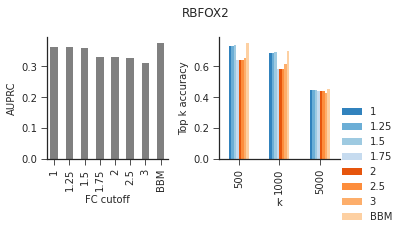

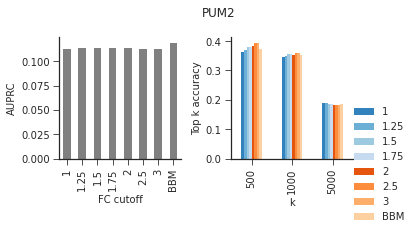

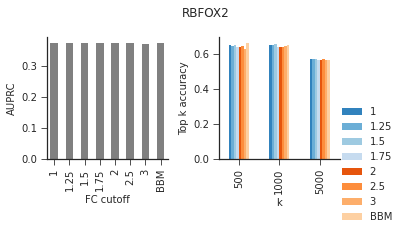

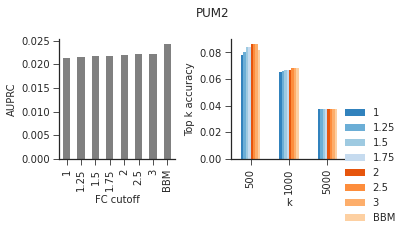

In [8]:
auprc_data = []
topk_data = []
for rbp in ['RBFOX2', 'PUM2']:
    auprc, topk = plot(rbp, truth_col = 'contain_eclip')
    auprc.name = f'{rbp}:label:eCLIP'
    topk['RBP'] = rbp
    topk['label']='eCLIP'

    auprc_data.append(auprc)
    topk_data.append(topk)
    plt.savefig(figdir / f'fc_DMM.{rbp}.eclip.pdf')
for rbp in ['RBFOX2', 'PUM2']:
    auprc, topk = plot(rbp, truth_col = 'contain_motif')
    auprc.name = f'{rbp}:label:motif'
    topk['RBP'] = rbp
    topk['label']='motif'
    auprc_data.append(auprc)
    topk_data.append(topk)
    plt.savefig(figdir / f'fc_DMM.{rbp}.motif.pdf')

In [9]:
auprc_data = pd.concat(auprc_data, axis = 1)
topk_data = pd.concat(topk_data)
topk_data.to_csv(figdir / f'k_DMM.{rbp}.topk.csv')
auprc_data.to_csv(figdir / f'k_DMM.{rbp}.auprc.csv')